## contents
* [introduction](#introduction)
* [imports, load and model setup](#imports)
* [naive bayes](#naive_bayes')
* [logistic regression](#logistic_regression)
* [random forest](#random_forest)
* [AdaBoost](#adaboost)
* [support vector machine](#svm)
* [model selection and conclusion](#conclusion)

## introduction <a id='introduction'></a>

The ideal use case for this model would be to identify what features of the available data set are the best predictors of a patient's readmission.  This could then inform clinicians on what to focus on during the inpatient stay.  For the single patient, any changes to care driven by this analysis would be good, so focusing on scoring models by the true positive rate would be ideal for this case.  However, as this would be used to inform clinician practice, alert fatigue should also be considered and the false positive rate must also be considered.  Tuning to the optimial threshold would be best left for the organization implementing the model and during the monitoring phase. 

For these reasons, the area under (AUC) then receiver operating characteristic (ROC) curve will be used to score models and visualized to understand the shape of that curve.  The relative importance of each feature will also be included.

## imports, load and model setup<a id='imports'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm


from sklearnex import patch_sklearn, config_context
patch_sklearn()

warnings.filterwarnings('ignore')
%matplotlib inline


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X_train = pd.read_parquet('../data/interim/X_train.parquet')
X_test = pd.read_parquet('../data/interim/X_test.parquet')
y_train = pd.read_parquet('../data/interim/y_train.parquet')
y_test = pd.read_parquet('../data/interim/y_test.parquet')

X_train_ind = X_train[X_train['is_independent'] == 1].copy()
X_test_ind = X_test[X_test['is_independent'] == 1].copy()
y_train_ind = y_train[y_train['is_independent'] == 1].copy()
y_test_ind = y_test[y_test['is_independent'] == 1].copy()

dataframes = [X_train, X_test, y_train, y_test, X_train_ind, X_test_ind, y_train_ind, y_test_ind]
for df in dataframes:
    df.drop('is_independent', axis=1, inplace=True)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_train_ind = np.ravel(y_train_ind)
y_test_ind = np.ravel(y_test_ind)

cross_validation = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [3]:
def sk_model(param_grid, model, cv, gpu=True, independent=False):

    X_train_local = X_train_ind if independent else X_train
    y_train_local = y_train_ind if independent else y_train
    X_test_local = X_test_ind if independent else X_test
    y_test_local = y_test_ind if independent else y_test
    
    grid_search = GridSearchCV(
            estimator=model, 
            param_grid=param_grid, 
            cv=cv)
    
    if gpu:
        with config_context(target_offload="gpu:0"):
            grid_search.fit(X_train_local, y_train_local)
    else:
        grid_search.fit(X_train_local, y_train_local)
        
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict_proba(X_test_local)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_local, y_pred)
    roc_auc = auc(fpr, tpr)

    print(f'Best parameters: {grid_search.best_params_}')

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkOrange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend(loc='lower right')
    plt.show()

    return grid_search.best_estimator_


## naive bayes<a id='naive_bayes'></a>

Naive Bayes will give a good baseline for other models.  

Best parameters: {}


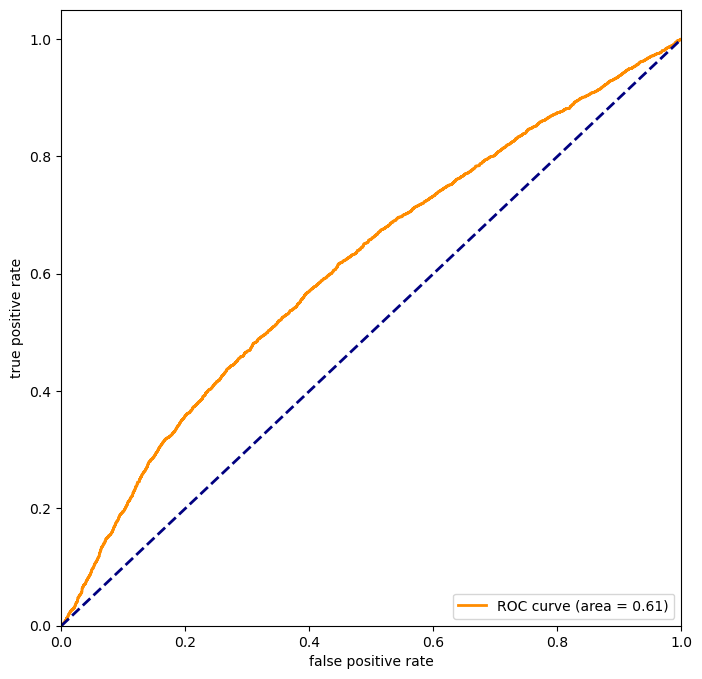

GaussianNB()

In [4]:
param_grid = {}

model = GaussianNB()
sk_model(param_grid=param_grid,
         model=model,
         cv=5,
         independent=True
        )

The baseline for other models is an AUC of 0.61 and there is a slight left learn to the curve indicating that increasing the threshold should be with some caution as the risk of alert fatigue increases somewhat quickly.

## logistic regression<a id='logistic_regression'></a>

As this is a binary classication problem, logistic regression is a logical next step.

In [5]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1','l2']
}

model = LogisticRegression(solver='liblinear', random_state=42)
model = sk_model(param_grid=param_grid,
                 model=model,
                 cv=cross_validation,
                 independent=True
)

coef = model.coef_[0]
coef = pd.DataFrame({'feature': X_train_ind.columns, 'coefficient': coef})
coef['abs'] = coef['coefficient'].abs()
coef_df = coef.sort_values(by='abs', ascending=False)
coef = coef_df.drop('abs', axis=1)
coef.head(10)

Logistic regression improves the AUC by 0.03 and removes the left lean giving a slower increase in alert fatigue.

- Unsurprisingly, whether or not the patient had another inpatient stay in the 12 months prior to this admission is the strongest predictor of a readmision.  
- Emergency encounters also weigh heavily.  
- It is unexpected that outpatient encounters have a positive coefficient however.  Ideally treatment in these settings would help to prevent inpatient admissions.  
- The weight of number_diagnoses is not surprising: "sicker" people are more likely to need inpatient care.  
- Admission type and source of other needs further investigation.  Perhaps, they should be removed during one hot encoding and the other categories created.  If these feature also has a high impact in the final model selection, this can be done.
- The top end age bucket is not surprising and likely related to whether or not they are discharged to care.  
- dx_cluster_5's weight is interesting and the dx codes with the strongest representation in that vector should be explored.
- alpha_gluc_inhibitor_class_NO with a negative weight is likely impacted by an underlying factor.  Perhaps this drug class is prescribed more often for the illnesses in dx_cluster_5
- race_Caucasion needs quite a bit of attention.  Is it that this is the result of racial bias in care or some other socio-demographic factor?  It could also have a genetic cause.  These are questions left to healthcare providers and administrators.

## random forest<a id='random_forest'></a>

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)
model = sk_model(param_grid=param_grid,
                 model=model,
                 cv=cross_validation,
                 independent=True)

feature_importance = pd.DataFrame({'feature': X_train_ind.columns, 'importance': model.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False).head(10)

Random forests perform slightly better than logistic regression with a similar behaviour for alert fatigue expected.

The features with the most importance in this model share some commonalities with logisitic regression, but also some differences.  Most notably, the num_lab_procedures, num_medication and num_procedures are present and the dx_cluster_5, alpha_gluc_inhibitor_class_No and age_[90-100) are missing.  Intuitively, increasing or decreaseing any of the additional treatments doesn't make sense.  "Do more labs to prevent readmission" is going to be a tough sell to clinicians.  

## AdaBoost<a id='adaboost'></a>

In [ ]:
param_grid = {
    'n_estimators': [25, 50, 100, 200],  
    'learning_rate': [0.5, 1, 1.5]
}

model = AdaBoostClassifier(random_state=42)

model = sk_model(param_grid=param_grid,
                 model=model,
                 cv=cross_validation,
                 independent=True
)

feature_importance = pd.DataFrame({'feature': X_train_ind.columns, 'importance': model.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False).head(10)

AdaBoost performs slightly worse than random forests and is similar to logistic regression.

This model has a similar problem to the random forest model in that the features that are most important are not readily actionable.  

## conclusion <a id='conclusion'></a>

All of the models tested had very similar AUC metrics and were not able to predict readmission well from this data set.  If any of them were to be used, explainability in both how the model was select and trained and what the results mean should be considered.  Clinicians will want to understand the details behind the model before they use it to treat patients.  They would also appreciate what they could expect to see with alert fatigue in increases thresholds.  The easier it is to understand the model, the more comfortable they will be with it.  Also, the more actionable the model's output, the more value they can gain from it.  This is subjective, but in this case, logistic regression will be the final mmodel selected.